## part 1 builidng 5 predictive models 

OLS 
LASSO 
Random Forest 
Boosting 
CART 

## importing 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import r2_score,mean_squared_error
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from IPython.display import Image, display

warnings.filterwarnings("ignore")

In [2]:

data_dir = "/Users/ghadena/Desktop/Business analytics/DA3/DA3/assignment_1/data"
path = os.path.join(data_dir,'test.csv') 
df = pd.read_csv(path)
df.head()

,f_room_type,f_property_type,f_room_type2,f_neighbourhood_cleansed,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,...,flag_days_since,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating
0,Entire,Apartment,Entire/Apt,Universidad,150.0,0,4,1.0,4.64,14,...,0,0,0,0,5.983936,35.807493,214.269759,156816.0,6.209914e+07,1.534714
1,Entire,Apartment,Entire/Apt,Universidad,137.0,0,4,1.0,4.58,31,...,0,0,0,0,5.866468,34.415447,201.897123,123904.0,4.361421e+07,1.521699
2,Entire,Apartment,Entire/Apt,Justicia,244.0,0,6,2.0,4.78,67,...,0,0,0,0,6.587550,43.395815,285.872103,525625.0,3.810781e+08,1.564441
3,Entire,Apartment,Entire/Apt,Argüelles,144.0,0,4,1.0,4.96,387,...,0,0,0,0,7.884200,62.160609,490.086666,7043716.0,1.869402e+10,1.601406
4,Entire,Apartment,Entire/Apt,Entrevías,69.0,0,4,1.0,3.73,11,...,0,0,0,0,6.133398,37.618572,230.729673,211600.0,9.733600e+07,1.316408


## EDA and sample design 
we did feature engineerng in the cleaning document 

In [3]:
df.isnull().sum().sum()

0

In [4]:
#We focus on normal apartments, n<8
df = df.loc[lambda x: x["n_accommodates"] < 8]

In [5]:
#Copy a variable - purpose later, see at variable importance
df = df.assign(n_accommodates_copy=df.n_accommodates)

In [6]:
df.describe()

,usd_price_day,p_host_response_rate,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_reviews_per_month,n_minimum_nights,n_beds,n_days_since,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,20233.000000,20233.0,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,20233.000000,...,20233.000000,20233.000000,20233.0,20233.000000,20233.000000,20233.000000,2.023300e+04,2.023300e+04,20233.000000,20233.000000
mean,117.980626,0.0,3.019473,1.253398,4.669453,53.026442,1.940280,7.060940,1.829931,6.282932,...,0.170415,0.170415,0.0,6.282932,40.894425,273.354686,1.725053e+06,4.461300e+09,1.534179,3.019473
std,91.768908,0.0,1.521987,0.595112,0.427763,93.815632,1.826741,17.356968,1.243126,1.191328,...,0.376006,0.376006,0.0,1.191328,13.978358,131.588942,3.234207e+06,1.158312e+10,0.135768,1.521987
min,1.000000,0.0,1.000000,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000
25%,60.000000,0.0,2.000000,1.000000,4.610000,2.000000,0.730000,1.000000,1.000000,5.710427,...,0.000000,0.000000,0.0,5.710427,32.608977,186.211182,9.060100e+04,2.727090e+07,1.528228,2.000000
50%,100.000000,0.0,3.000000,1.000000,4.760000,15.000000,1.460000,2.000000,2.000000,6.388561,...,0.000000,0.000000,0.0,6.388561,40.813717,260.740936,3.528360e+05,2.095846e+08,1.560248,3.000000
75%,147.000000,0.0,4.000000,1.000000,4.880000,61.000000,2.540000,3.000000,2.000000,7.023759,...,0.000000,0.000000,0.0,7.023759,49.333190,346.504434,1.258884e+06,1.412468e+09,1.585145,4.000000
max,999.000000,0.0,7.000000,12.000000,5.000000,1092.000000,41.220000,364.000000,40.000000,8.546364,...,1.000000,1.000000,0.0,8.546364,73.040330,624.229217,2.649161e+07,1.363523e+11,1.609438,7.000000


In [7]:
# Identify columns with only one unique value
columns_to_drop = [col for col in df.columns if df[col].nunique() == 1]
print(f"Columns to drop: {columns_to_drop}")

# Drop the identified columns
df = df.drop(columns=columns_to_drop)
print("Dropped columns with only one unique value.")

#print(data_train[["price", "usd_price_day"]].corr())
#df = df.drop(columns=["d_unnamed:59", "usd_price_day"])
df = df.drop(columns=["usd_price_day"])

Columns to drop: ['p_host_response_rate', 'd_free_residential_garage_on_premises_2_spaces', 'd_friday_included_with_your_stay', 'd_monday', 'd_peque_o_para_pizza', 'd_thursday_included_with_your_stay', 'flag_n_number_of_reviews']
Dropped columns with only one unique value.


In [8]:
#print(df.d_airconditioning.value_counts().sum())
print(df.d_view.value_counts())
df.shape

d_view
1    16898
0     3335
Name: count, dtype: int64


(20233, 237)

## Creating train and hold out sets 

In [9]:
data_train, data_test = train_test_split(df, train_size=0.7, random_state=42)
data_train.shape, data_test.shape

((14163, 237), (6070, 237))

In [10]:
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_neighbourhood_cleansed",
]

reviews = [
    "n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

amenities = [col for col in df if col.startswith("d_")]

X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "n_accommodates:n_bathrooms", 
    "n_accommodates:f_room_type", 
    #"n_accommodates:d_airconditioning", 
    #"n_review_scores_rating:d_pets_allowed", 
    "n_review_scores_rating:d_child_friendly", 
    "n_review_scores_rating:d_free_parking",
    "n_accommodates:d_housekeeping_included",
    "n_review_scores_rating:d_housekeeping_included",
    "d_housekeeping_included:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2

In [11]:
import re
from patsy import dmatrices

# Clean column names to remove special characters
data_train.columns = data_train.columns.str.replace(r"[^\w\s]", "_", regex=True)

# Update predictors_2 to match cleaned column names
predictors_1_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_1]
predictors_2_cleaned = [re.sub(r"[^\w\s]", "_", col) for col in predictors_2]
predictors_E_cleaned = [re.sub(r"[^\w\s:]", "_", col) for col in predictors_E]

# Ensure the cleaned column names are in the dataframe
data_train = data_train.rename(columns=dict(zip(predictors_2, predictors_2_cleaned)))


In [12]:

# # Create missing interaction columns
# for var in X1 + X2:
#     if var not in data_train.columns:
#         # Split the interaction term to get the individual columns
#         col1, col2 = var.split(":")
#         # Create the interaction term
#         data_train[var] = data_train[col1] * data_train[col2]
#         print(f"Created column: {var}")
#     else:
#         print(f"Column already exists: {var}")
        
# # Check the data types of the newly created columns
# for var in X1 + X2:
#     print(f"{var}: {data_train[var].dtype}")

In [13]:
# for var in X1 + X2: 
#     if var  not in data_train.columns:
#         #print(var) 
#         data_train[var] = data_train['f_property_type'] + ":" + data_train['f_neighbourhood_cleansed']
#         print(True)
#     else:
#         print(var)
#         print(False)

## OLS 

In [14]:
predictors_list = [
    predictors_1_cleaned,
    predictors_2_cleaned,
    predictors_E_cleaned
]

# Loop through the predictors, fit the model, and extract the metrics
for i, predictors_cleaned in enumerate(predictors_list, start=1):

    # Create design matrices
    y, X = dmatrices("price ~ " + " + ".join(predictors_cleaned), data_train)

    # Fit the OLS model
    model = sm.OLS(y, X).fit()

    # Extract the R-squared value
    r_squared = model.rsquared

    # Extract the BIC value
    bic = model.bic

    # Calculate the RMSE
    rmse = np.sqrt(model.mse_resid)

    # Print the extracted values
    print(f"Model {i}:")
    print(f"R-squared: {r_squared}")
    print(f"BIC: {bic}")
    print(f"RMSE: {rmse}")
    print("\n")

Model 1:
R-squared: 0.3418964891202958
BIC: 163694.2608988179
RMSE: 74.95001931424191


Model 2:
R-squared: 0.4177532380892617
BIC: 163708.93331545134
RMSE: 70.96287831993624


Model 3:
R-squared: 0.4905625929398194
BIC: 167666.66920490016
RMSE: 67.89631864049521




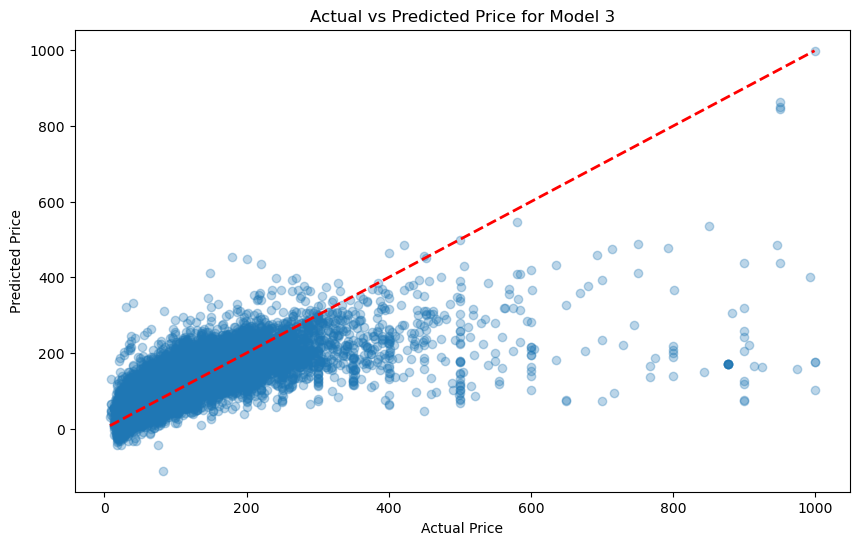

In [15]:

# Create design matrices for model 3
y, X = dmatrices("price ~ " + " + ".join(predictors_E_cleaned), data_train)

# Fit the OLS model for model 3
model_ols = sm.OLS(y, X).fit()

# Predict the values
y_hat = model_ols.predict(X)

# Plot the predicted values versus the actual values
plt.figure(figsize=(10, 6))
plt.scatter(y, y_hat, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price for Model 3')
plt.show()

## Chart 

In [16]:
def price_diff_by_variables(df, factor_var, dummy_var, factor_lab, dummy_lab):
    # Calculate statistics same way as before
    stats = df.groupby([factor_var, dummy_var]).agg(
        Mean=("price", np.mean), 
        sd=("price", np.std), 
        size=("price", "size")
    )
    stats["se"] = stats["sd"] / stats["size"] ** (1/2)
    stats["Mean_l"] = stats["Mean"] - (1.96 * stats["se"])
    stats["Mean_u"] = stats["Mean"] + (1.96 * stats["se"])
    stats = stats.drop(["sd", "size"], axis=1).reset_index()

    # Create the plot using seaborn
    # plt.figure(figsize=(10, 6))
    plt.figure()

    # Create bar plot
    ax = sns.barplot(
        data=stats,
        x=stats.columns[0],
        y='Mean',
        hue=stats.columns[1],
        palette=['indianred', 'steelblue'],
        ci=None
    )

    # Add error bars
    for i, group in enumerate(stats[stats.columns[1]].unique()):
        group_data = stats[stats[stats.columns[1]] == group]
        x = np.arange(len(group_data))

        # Adjust x positions for dodge effect
        x = x + 0.2 if i == 1 else x - 0.2
        plt.errorbar(
            x=x, 
            y=group_data['Mean'],
            yerr=[(group_data['Mean'] - group_data['Mean_l']), 
                  (group_data['Mean_u'] - group_data['Mean'])],
            fmt='none',
            color='black',
            capsize=3
        )

    # Customize the plot
    plt.xlabel(factor_lab)
    plt.ylabel('Mean Price')

    # Customize legend
    plt.legend(
        title=dummy_lab,
        bbox_to_anchor=(0.5, 1.15),
        loc='center',
        ncol=2,
        fontsize=10,
        title_fontsize=10
    )

    # Remove grid
    ax.grid(False)
    plt.show()

    return plt



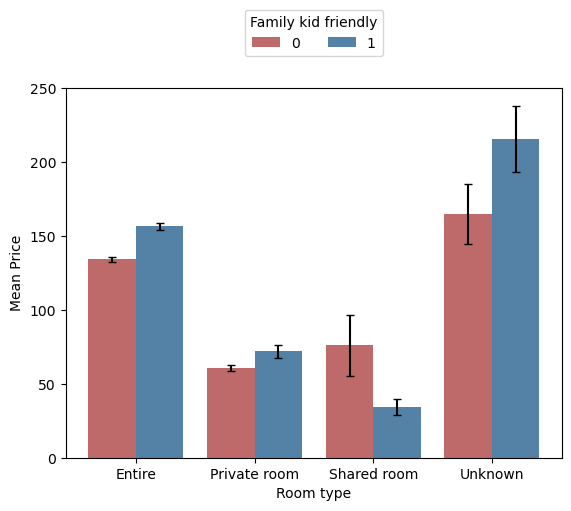

In [17]:
price_diff_by_variables(df,"f_room_type","d_child_friendly","Room type", "Family kid friendly");

## LASSO 

In [18]:
from sklearn.model_selection import GridSearchCV


In [19]:
from sklearn.linear_model import Lasso
import patsy
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler


#%%time

# define model
model = Lasso()
# define model evaluation method
cv = RepeatedKFold(n_splits = 5, n_repeats = 1, random_state = 20250217)
# define grid
grid = dict()
grid["alpha"] = np.arange(0.05, 1, 0.05)
# define search
search = GridSearchCV(model, grid, scoring="neg_root_mean_squared_error", cv = cv, verbose= 3) # control your output with the 'verbose' option
# perform the search
results = search.fit(X, y)

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV 1/5] END ......................alpha=0.05;, score=-77.597 total time=   1.2s
[CV 2/5] END ......................alpha=0.05;, score=-65.629 total time=   2.6s
[CV 3/5] END ......................alpha=0.05;, score=-71.538 total time=   2.9s
[CV 4/5] END ......................alpha=0.05;, score=-67.857 total time=   5.3s
[CV 5/5] END ......................alpha=0.05;, score=-68.480 total time=   7.3s
[CV 1/5] END .......................alpha=0.1;, score=-78.292 total time=   0.8s
[CV 2/5] END .......................alpha=0.1;, score=-65.722 total time=   0.9s
[CV 3/5] END .......................alpha=0.1;, score=-72.953 total time=   0.9s
[CV 4/5] END .......................alpha=0.1;, score=-68.013 total time=   0.8s
[CV 5/5] END .......................alpha=0.1;, score=-68.021 total time=   0.8s
[CV 1/5] END .......alpha=0.15000000000000002;, score=-78.789 total time=   0.6s
[CV 2/5] END .......alpha=0.15000000000000002;, 

finding the alpha param for lasso using the train set 
The “best” alpha corresponds to the least negative RMSE (i.e., closest to zero). 
 GridSearchCV selects the alpha with the lowest validation RMSE.
✅ Since 0.05 had the best RMSE, it means that removing too many features hurt performance.
A high number of variables doesn’t always mean high alpha is needed, especially if many variables contribute small amounts of predictive power.
Impact of Alpha = 0.05
	1.	Less Regularization, More Features
	•	Since 0.05 is a small alpha, it doesn’t shrink coefficients much.
	•	The model keeps more variables in the regression.
	•	Helps prevent underfitting, meaning the model captures more detail from the data.
	2.	Better RMSE
	•	In your case, α = 0.05 had the lowest RMSE, meaning it provided the best balance between:
	•	Bias (not too simple)
	•	Variance (not overfitting)
	3.	Comparison with Higher Alpha
	•	If α were larger (e.g., 0.95), Lasso would shrink more coefficients to zero, removing some predictors.
	•	This would make the model simpler but might increase RMSE if too many useful features are removed.




In [20]:
import numpy as np

avg_rmse_per_alpha = {
    alpha: -mean_rmse for alpha, mean_rmse in zip(
        search.cv_results_["param_alpha"].data,  # Extract alpha values
        search.cv_results_["mean_test_score"]    # Extract mean negative RMSE
    )
}

print(avg_rmse_per_alpha)

{0.05: 70.22024776251274, 0.1: 70.60028208142971, 0.15000000000000002: 70.87940515188055, 0.2: 71.0950688956493, 0.25: 71.26980985485314, 0.30000000000000004: 71.43448467900204, 0.35000000000000003: 71.58812832454439, 0.4: 71.7336760579681, 0.45: 71.87869795530541, 0.5: 72.01879200174658, 0.55: 72.14640599378933, 0.6000000000000001: 72.25830768651704, 0.65: 72.37192624898827, 0.7000000000000001: 72.48133006296722, 0.75: 72.59376540480282, 0.8: 72.70486983960352, 0.8500000000000001: 72.82065984029582, 0.9: 72.94060918965167, 0.9500000000000001: 73.06164782335027}


In [21]:
# Find the best alpha (with the lowest average RMSE)
best_alpha = min(avg_rmse_per_alpha, key=avg_rmse_per_alpha.get)
best_avg_rmse = avg_rmse_per_alpha[best_alpha]

print(f"Best alpha: {best_alpha}, Best average RMSE: {best_avg_rmse}")

Best alpha: 0.05, Best average RMSE: 70.22024776251274


In [22]:
import numpy as np

lasso = search.best_estimator_  # Best model from GridSearchCV
num_nonzero = np.sum(lasso.coef_ != 0)

print(f"Number of nonzero coefficients: {num_nonzero} / {len(lasso.coef_)}")

print(search.best_estimator_.coef_.shape)  # number of features

#Lasso used 1,645 features instead of 226 because preprocessing expanded the dataset.
#Possible reasons: One-hot encoding, polynomial features, dummy variables, or text vectorization.

Number of nonzero coefficients: 226 / 1656
(1656,)


In [23]:
feature_importance = dict(zip(data_train.columns, lasso.coef_))
sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

print("Top 10 most important features:")
for feature, coef in sorted_features[:10]:
    print(f"{feature}: {coef:.4f}")

Top 10 most important features:
n_number_of_reviews: -44.6927
d_pool_cover: 43.1867
n_reviews_per_month: -40.2842
d_pool: -32.1143
f_neighbourhood_cleansed: 22.1134
d_pool_table: -11.2965
d_contiene_alimentos_nuestros: -7.1861
d_coffee_maker: 6.2321
n_beds: 5.3316
n_accommodates: -4.4740


## CART

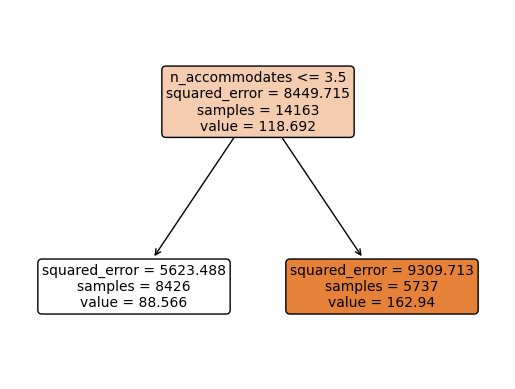

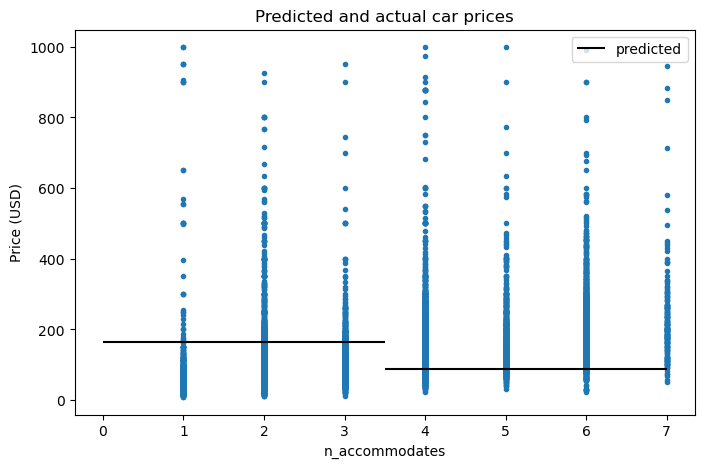

In [24]:
cart1 = DecisionTreeRegressor(random_state = 20250217, max_depth = 1)

# Note X should be a matrix instead of series, that's why we need double []
X = data_train[['n_accommodates']]
y = data_train['price']
cart1.fit(X,y)

pred_cart1 = cart1.predict(data_train[["n_accommodates"]])

rmse_cart1 = np.sqrt(mean_squared_error(data_train["price"], pred_cart1))

from sklearn import tree
tree.plot_tree(cart1, filled = True, rounded = True, feature_names=["n_accommodates"], fontsize = 10);


pred_cart1t = cart1.predict(data_train[['n_accommodates']])
cart1.tree_.threshold

cart1_cuts = cart1.tree_.threshold[cart1.tree_.threshold != -2]


df_plot = data_train
df_plot['predicted_price'] = pred_cart1t
df_plot.sort_values(by = 'n_accommodates', inplace = True)

plt.figure(figsize = (8,5))
plt.scatter(x = df_plot.n_accommodates, y = df_plot.price, marker = '.')
plt.hlines(df_plot.predicted_price.max(), 0, cart1_cuts, color = 'k')
plt.hlines(df_plot.predicted_price.min(), cart1_cuts, df_plot.n_accommodates.max(), color = 'k', label = 'predicted')
plt.legend()
plt.ylabel('Price (USD)')
plt.xlabel('n_accommodates')
plt.title('Predicted and actual car prices')
plt.show();

In [25]:
# Create design matrices for the training set
formula = "price ~ " + " + ".join(predictors_2_cleaned)
y, X = dmatrices(formula, data_train, return_type='dataframe')


cart4 = DecisionTreeRegressor(
    random_state=20250217,
    criterion="squared_error",
    min_impurity_decrease=25,
    min_samples_split=20,
)
print(cart4.fit(X, y))

y_test, X_test = dmatrices(formula, data_test, return_type='dataframe')

# Align the columns of the test set with the training set
X_test = X_test.reindex(columns=X.columns, fill_value=0)

pred_cart4 = cart4.predict(X_test)
rmse_cart4 = np.sqrt(mean_squared_error(y_test, pred_cart4))
print(rmse_cart4)

# df_cart4_var_imp = (
#     pd.DataFrame(
#         {'variable': X_test.columns, 
#          'importance': cart4.feature_importances_}
#     ).sort_values(
#         by=["importance"], ascending=False
#     ).reset_index(drop = True)
# )

# print(df_cart4_var_imp)




DecisionTreeRegressor(min_impurity_decrease=25, min_samples_split=20,
                      random_state=20250217)
73.90049194006707


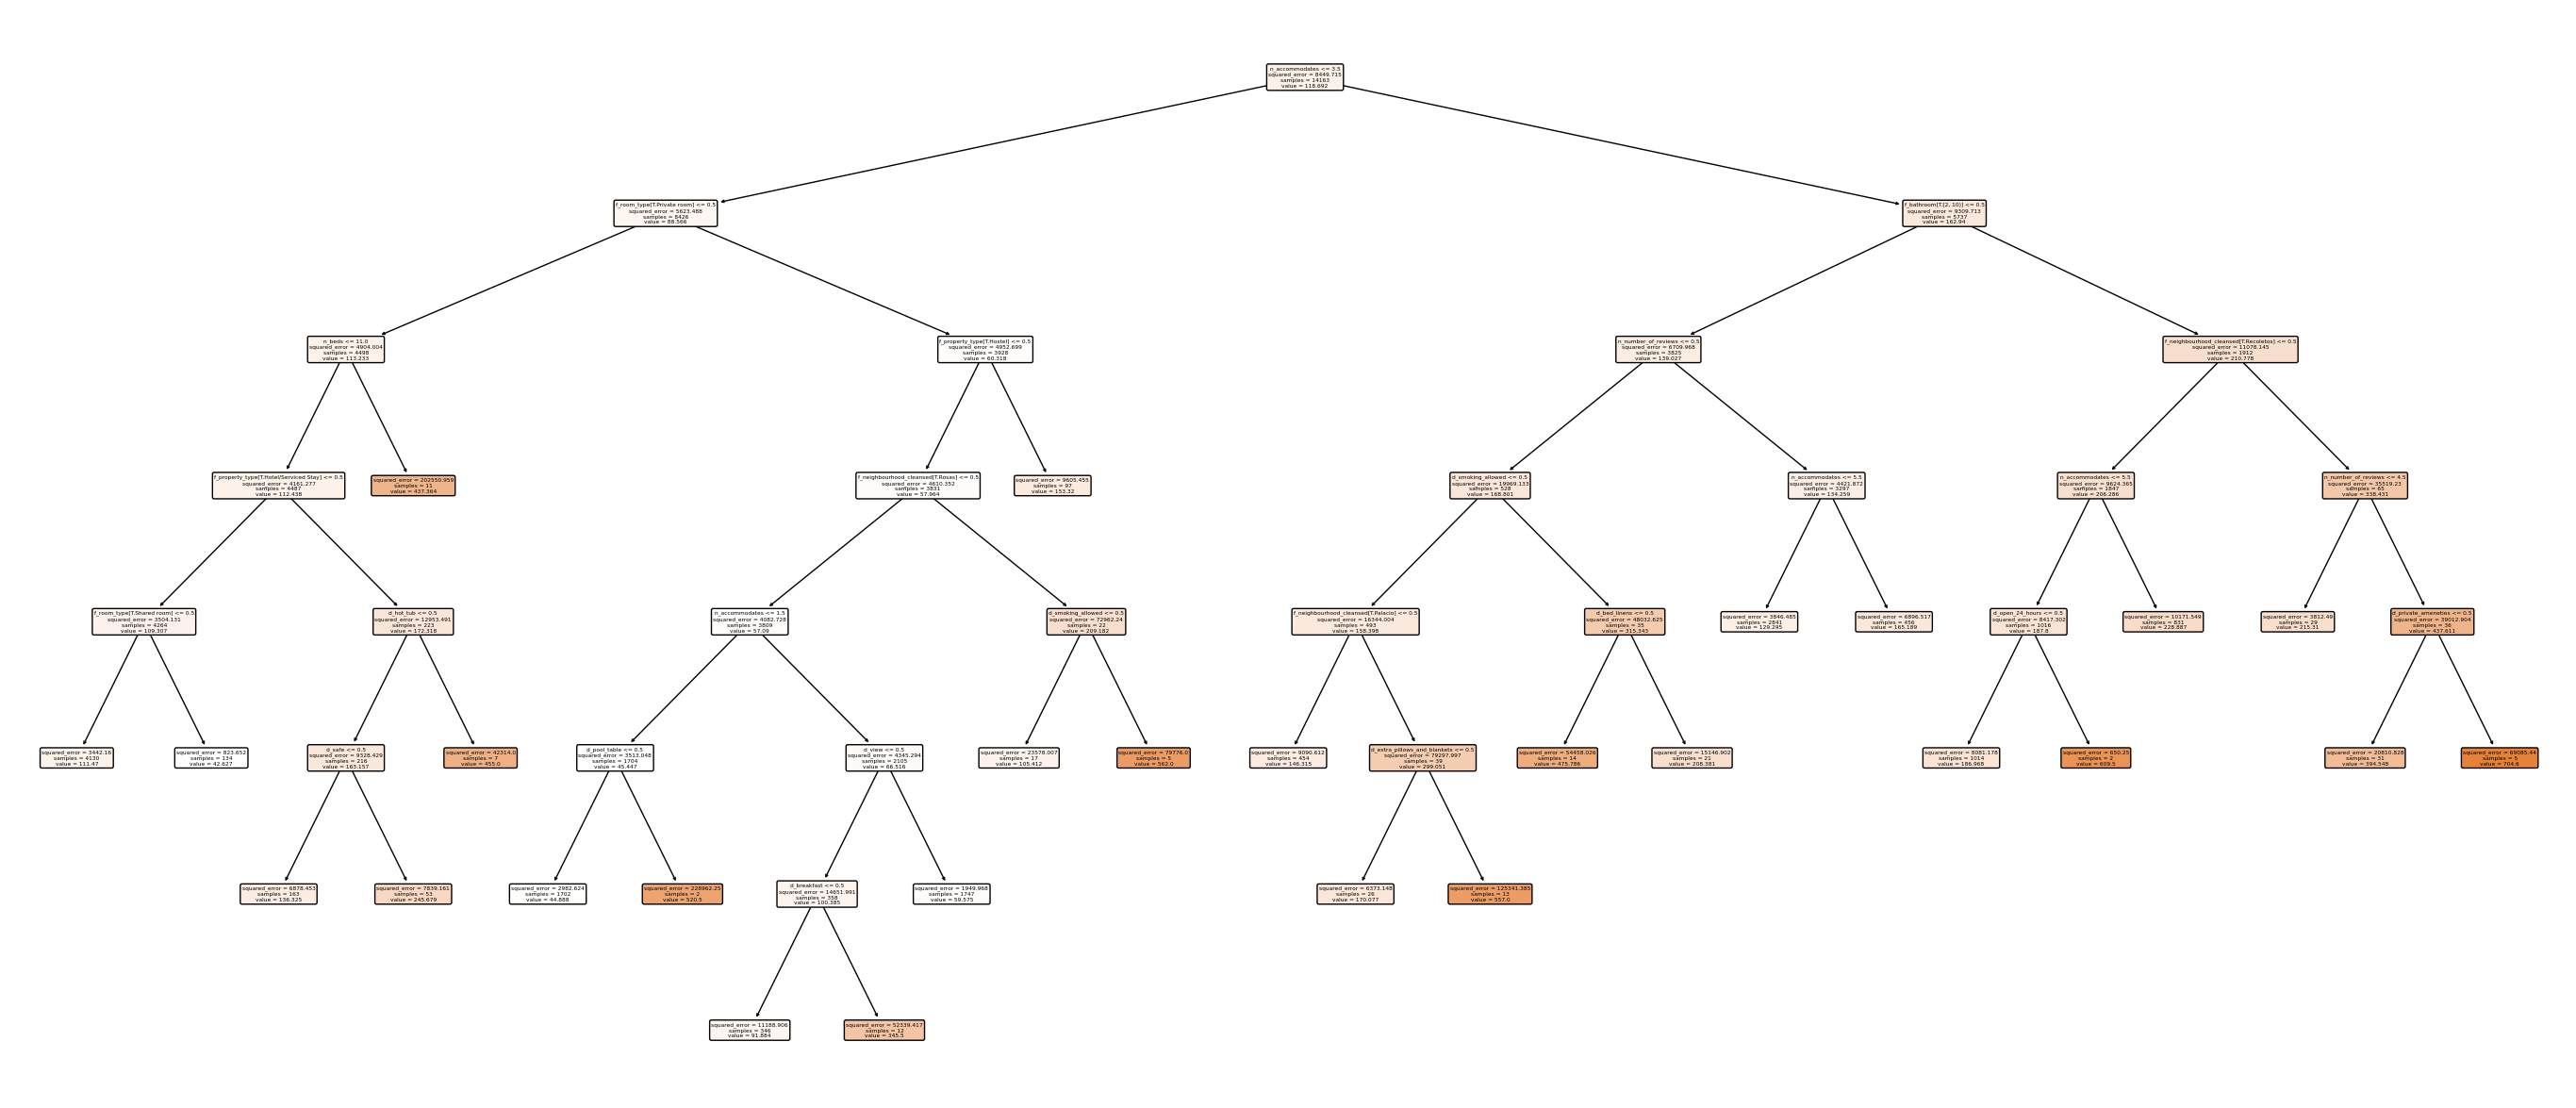

In [26]:
plt.figure(figsize = (35,15))
tree.plot_tree(cart4, filled = True, feature_names= X.columns, rounded = True);

In [27]:
df_cart4_var_imp = (
    pd.DataFrame(
        {'variable': X_test.columns, 
         'importance': cart4.feature_importances_}
    ).sort_values(
        by=["importance"], ascending=False
    ).reset_index(drop = True)
)

print(df_cart4_var_imp)

                                      variable  importance
0                               n_accommodates    0.435107
1                        f_bathroom[T.[2, 10)]    0.138779
2                  f_room_type[T.Private room]    0.124153
3                            d_smoking_allowed    0.034055
4                          n_number_of_reviews    0.028267
..                                         ...         ...
343  f_neighbourhood_cleansed[T.San Cristobal]    0.000000
344     f_neighbourhood_cleansed[T.San Andrés]    0.000000
345       f_neighbourhood_cleansed[T.Salvador]    0.000000
346     f_neighbourhood_cleansed[T.Rios Rosas]    0.000000
347                              d_bread_maker    0.000000

[348 rows x 2 columns]
